In [1]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import re 
from collections import Counter
from string import punctuation
import textstat # pip install textstat

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [2]:
df = pd.read_csv('../Datasets/Modified_Books_rating.csv')
df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...


In [16]:
# ARI
def calculate_ari(text):
    ari = textstat.automated_readability_index(text)
    return ari

df['ARI'] = df['Review'].apply(calculate_ari)
# number of reviews with an ARI < 8 (equals 3rd grade level and is very easy to read)
low_ari_reviews = df[df['ARI'] < 8]
num_low_ari_reviews = len(low_ari_reviews)
def convert_ari(df):
    if df['ARI'] <= 8.0:
        ari = 1 # for readable
    else:
        ari = 0 # for not readable
    return ari

df['IsReadable'] = df.apply(convert_ari, axis=1)


# punctuation
# Get punctuation ratio (! and ?)
df['ExclamationMarks_Count'] = df['Review'].str.count('!')
df['QuestionMarks_Count'] = df['Review'].str.count('\?')

# Calculate Ratio/Percent of Punc. Marks relative to review length
df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Count'] / df['review_len']
df['QuestionMarks_Ratio'] = df['QuestionMarks_Count'] / df['review_len']

df['ExclamationMarks_Ratio'] = df['ExclamationMarks_Ratio'].fillna(0)
df['QuestionMarks_Ratio'] = df['QuestionMarks_Ratio'].fillna(0)

df['ExclamationMarks_Percent'] = (df['ExclamationMarks_Ratio'] * 100).astype(int)
df['QuestionMarks_Percent'] = (df['QuestionMarks_Ratio'] * 100).astype(int)

# combine both
df['Sum_punctuationMarks'] = df['ExclamationMarks_Percent'] + df['QuestionMarks_Percent']

# delete unused columns:
df.drop(['ExclamationMarks_Count', 'QuestionMarks_Count','ExclamationMarks_Ratio', 'QuestionMarks_Ratio','ExclamationMarks_Percent', 'QuestionMarks_Percent'], axis='columns', inplace=True)


# capslock
df['Capslock_Count'] = df['Review'].str.findall(r'\b(?![Ii]\b)[A-Z]+\b').str.len()
df['Capslock_Ratio'] = df['Capslock_Count'] / df['review_len']
df['Capslock_Ratio'] = df['Capslock_Ratio'].fillna(0)
df['Capslock_Percent'] = (df['Capslock_Ratio'] * 100).astype(int)
df.drop(['Capslock_Count','Capslock_Ratio'], axis='columns', inplace=True)


# updates
df['contains_updates'] = df['cleaned_reviews'].str.contains('edit|update', case=False).astype(int)

In [17]:
df.head()

,Title,helpful,Rating,Title.1,Review,helpful_0,helpful_1,ratio_percent,review_len,IsHelpful,cleaned_reviews,ARI,IsReadable,Sum_punctuationMarks,Capslock_Percent,contains_updates
0,Alaska Sourdough,36/37,5.0,Real Alaskan Sourdough,Ruth Allman has written an excellent book abou...,36,37,97,153,1,ruth allman written excellent book alaskan sou...,8.1,0,0,0,0
1,Alaska Sourdough,29/30,5.0,True Alaskan cooking,"I have been using this book since 1988, the ei...",29,30,96,63,1,i using book since eighth printing i honestly ...,5.7,1,1,0,0
2,Alaska Sourdough,25/28,5.0,Cheechako to Sourdough in 190 Pages,"My poor dogeared, stained copy of this book ca...",25,28,89,206,1,my poor dogeared stained copy book came way da...,7.6,1,1,0,0
3,Eyewitness Travel Guide to Europe,3/20,1.0,Disappointed Romanian!,This book in my opinion is biased and takes an...,3,20,15,92,0,this book opinion biased take angle europe cle...,10.9,0,0,1,0
4,Eyewitness Travel Guide to Europe,20/20,5.0,Going to Europe? Get this book!,If you're already a fan of the Eyewitness Trav...,20,20,100,234,1,if youre already fan eyewitness travel guide s...,18.3,0,0,1,0


In [18]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum()

# Print the missing values
print(missing_values)

# delete missing values
df = df.dropna()

Title                   0
helpful                 0
Rating                  0
Title.1                 0
Review                  0
helpful_0               0
helpful_1               0
ratio_percent           0
review_len              0
IsHelpful               0
cleaned_reviews         0
ARI                     0
IsReadable              0
Sum_punctuationMarks    0
Capslock_Percent        0
contains_updates        0
dtype: int64


In [19]:
print("Data type of 'contains_updates':", df['contains_updates'].dtype)
unique_values_contains_updates = df['contains_updates'].unique()
print("Unique values in 'contains_updates':", unique_values_contains_updates)



Data type of 'contains_updates': int64
Unique values in 'contains_updates': [0 1]


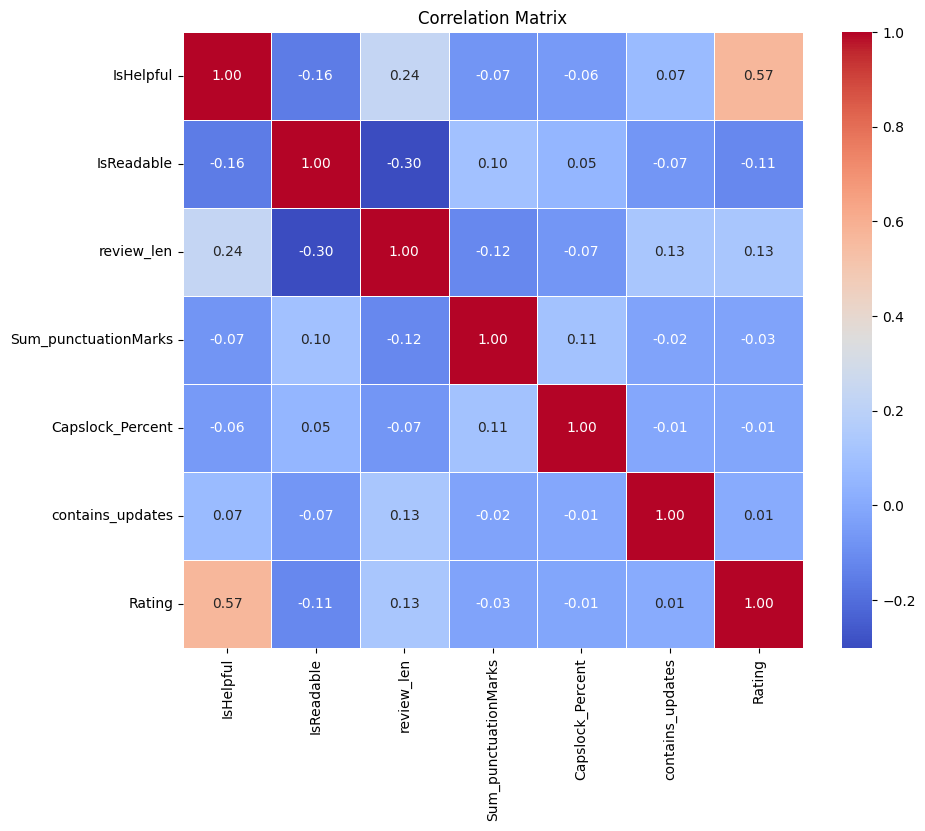

In [22]:
# correlation matrix for factors
variables = ['IsHelpful', 'IsReadable', 'review_len', 'Sum_punctuationMarks', 'Capslock_Percent', 'contains_updates', 'Rating']

# Select the relevant columns from your DataFrame
selected_data = df[variables]

# Create a correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()